In [6]:
import torch
from torch.autograd import Function

class SwishFunction(Function):
    """
    Custom autograd function implementing the Swish activation:
    f(x) = x * sigmoid(beta * x)
    """
    
    @staticmethod
    def forward(ctx, input, beta=1.0):
        
        # Save variables needed for backward pass
        sigmoid_output = torch.sigmoid(beta * input)
        ctx.save_for_backward(input, sigmoid_output)
        ctx.beta = beta
        
        # Compute the forward pass: x * sigmoid(beta * x)
        output = input * sigmoid_output
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
       
        # Retrieve saved variables
        input, sigmoid_output = ctx.saved_tensors
        beta = ctx.beta
        
        # Calculate gradient for input
        # d/dx[x * sigmoid(beta * x)] = 
        # sigmoid(beta * x) + x * sigmoid(beta * x) * (1 - sigmoid(beta * x)) * beta
        sigmoid_derivative = sigmoid_output * (1 - sigmoid_output) * beta
        dx = sigmoid_output + input * sigmoid_derivative
        
        # Multiply by incoming gradient (chain rule)
        grad_input = grad_output * dx

        # Return gradients for each input to forward
        # None for beta as we're not computing its gradient
        return grad_input, None

# Wrapper module for our custom Function
class Swish(torch.nn.Module):
    def __init__(self, beta=1.0):
        super(Swish, self).__init__()
        self.beta = beta
        
    def forward(self, x):
        return SwishFunction.apply(x, self.beta)

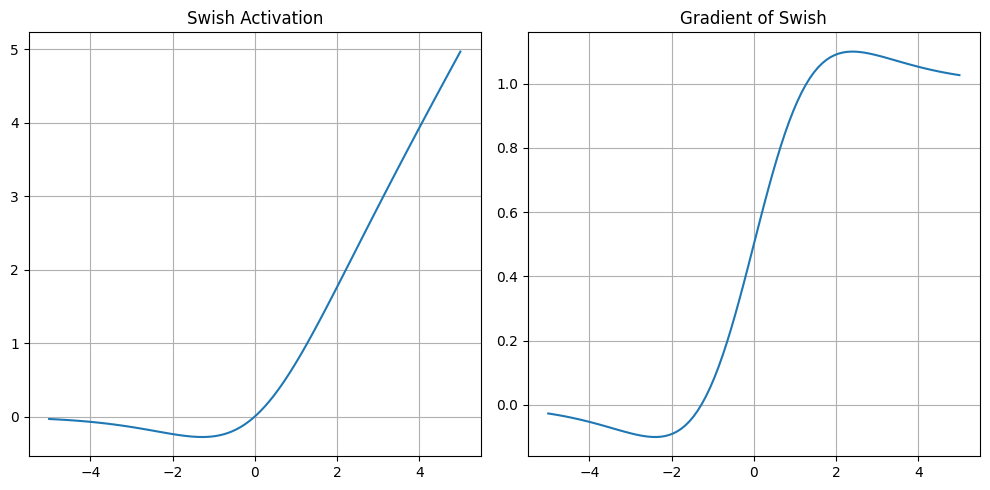

Autograd gradients match numerical gradients: False


In [7]:
import torch
import matplotlib.pyplot as plt

# Test the custom Swish function
def test_swish():
    # Create a tensor that requires gradients
    x = torch.linspace(-5, 5, 100, requires_grad=True)
    
    # Apply our custom function
    swish = Swish(beta=1.0)
    y = swish(x)
    
    # Compute gradients
    z = y.sum()
    z.backward()
    
    # Plot the function and its gradient
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x.detach().numpy(), y.detach().numpy())
    plt.title('Swish Activation')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(x.detach().numpy(), x.grad.numpy())
    plt.title('Gradient of Swish')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Verify with numerical gradient
    print("Autograd gradients match numerical gradients:", 
          verify_gradients(Swish(beta=1.0), x))
    
# Helper function to verify gradients using finite differences
def verify_gradients(func, inputs, eps=1e-6):
    # Get analytical gradients
    inputs.grad = None  # Reset gradients
    inputs_clone = inputs.detach().clone().requires_grad_(True)
    outputs = func(inputs_clone)
    outputs.sum().backward()
    analytical_grads = inputs_clone.grad.clone()
    
    # Compute numerical gradients
    numerical_grads = torch.zeros_like(inputs)
    
    for i in range(inputs.numel()):
        # Forward difference
        inputs_plus = inputs.detach().clone()
        inputs_plus[i] = inputs_plus[i] + eps
        outputs_plus = func(inputs_plus)
        
        # Backward difference
        inputs_minus = inputs.detach().clone()
        inputs_minus[i] = inputs_minus[i] - eps
        outputs_minus = func(inputs_minus)
        
        # Central difference gradient
        numerical_grads[i] = (outputs_plus - outputs_minus).sum() / (2 * eps)
    
    # Check if gradients are close
    return torch.allclose(analytical_grads, numerical_grads, rtol=1e-3, atol=1e-3)

# Run the test
if __name__ == "__main__":
    test_swish()
    

Epoch 1/10 - Swish Loss: 2.2266, ReLU Loss: 1.9641
Epoch 2/10 - Swish Loss: 1.7547, ReLU Loss: 1.4233
Epoch 3/10 - Swish Loss: 1.2713, ReLU Loss: 1.2379
Epoch 4/10 - Swish Loss: 1.0210, ReLU Loss: 1.0683
Epoch 5/10 - Swish Loss: 0.9323, ReLU Loss: 0.9547
Epoch 6/10 - Swish Loss: 0.8718, ReLU Loss: 0.8523
Epoch 7/10 - Swish Loss: 0.7427, ReLU Loss: 0.6917
Epoch 8/10 - Swish Loss: 0.6081, ReLU Loss: 0.5293
Epoch 9/10 - Swish Loss: 0.4551, ReLU Loss: 0.3678
Epoch 10/10 - Swish Loss: 0.2852, ReLU Loss: 0.2471


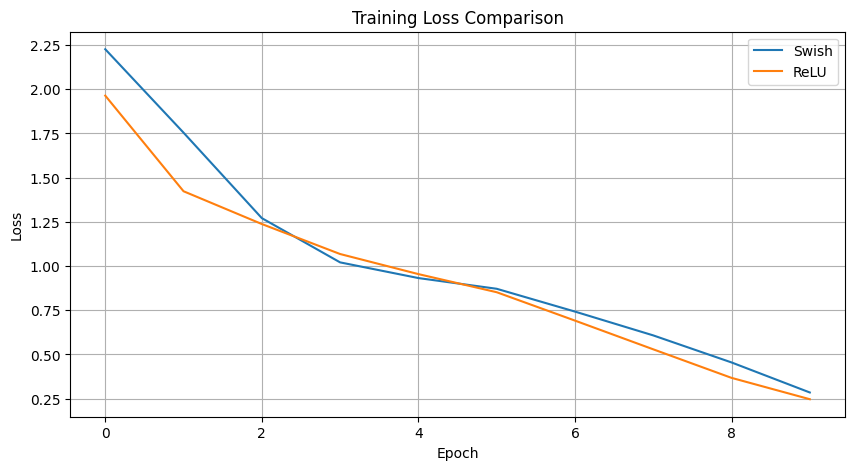

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define a simple neural network with our custom activation
class SimpleNet(nn.Module):
    def __init__(self, activation='swish', beta=1.0):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
        
        if activation == 'swish':
            self.activation = Swish(beta=beta)
        elif activation == 'relu':
            self.activation = nn.ReLU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")
            
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the model with our custom activation
def train_model():
    # Generate some random data
    np.random.seed(42)
    X = np.random.randn(1000, 10).astype(np.float32)
    # Create a non-linear function for regression
    y = (X[:, 0] * X[:, 1] + np.sin(X[:, 2]) + np.exp(X[:, 3] * 0.1)).reshape(-1, 1).astype(np.float32)
    
    # Create PyTorch tensors and dataset
    X_tensor = torch.from_numpy(X)
    y_tensor = torch.from_numpy(y)
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Create models with different activations for comparison
    swish_model = SimpleNet(activation='swish', beta=1.0)
    relu_model = SimpleNet(activation='relu')
    
    # Training parameters
    criterion = nn.MSELoss()
    swish_optimizer = optim.Adam(swish_model.parameters(), lr=0.001)
    relu_optimizer = optim.Adam(relu_model.parameters(), lr=0.001)
    
    # Training loop
    epochs = 10
    swish_losses = []
    relu_losses = []
    
    for epoch in range(epochs):
        swish_epoch_loss = 0.0
        relu_epoch_loss = 0.0
        
        for batch_X, batch_y in dataloader:
            # Train Swish model
            swish_optimizer.zero_grad()
            swish_outputs = swish_model(batch_X)
            swish_loss = criterion(swish_outputs, batch_y)
            swish_loss.backward()
            swish_optimizer.step()
            swish_epoch_loss += swish_loss.item()
            
            # Train ReLU model
            relu_optimizer.zero_grad()
            relu_outputs = relu_model(batch_X)
            relu_loss = criterion(relu_outputs, batch_y)
            relu_loss.backward()
            relu_optimizer.step()
            relu_epoch_loss += relu_loss.item()
            
        # Record average epoch loss
        swish_losses.append(swish_epoch_loss / len(dataloader))
        relu_losses.append(relu_epoch_loss / len(dataloader))
        
        print(f"Epoch {epoch+1}/{epochs} - Swish Loss: {swish_losses[-1]:.4f}, ReLU Loss: {relu_losses[-1]:.4f}")
    
    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.plot(swish_losses, label='Swish')
    plt.plot(relu_losses, label='ReLU')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Run the training
if __name__ == "__main__":
    train_model()